In [3]:
import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat,savemat
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras import models
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

In [4]:
# Cette fonction permettra plus tard de charger plus ou moins d'images (en modifiant le paramètre num_images)
# et de modifier la dimension d'entrée
def load_data(image_size, num_images,path):
  dirs = sorted(os.listdir(path))

  x = np.zeros((min(num_images,len(dirs)),image_size,image_size))
  y = np.zeros((min(num_images,len(dirs)), 3))
    
  #Chargement des normals    
  mat_contents = loadmat(path+'/normals.mat')
  normals = mat_contents['normals']
  normals =tf.squeeze(normals)
  #print(normals)

  # Chargement des images, qui sont rangées dans lsp/images
  for i in range(min(num_images,len(dirs))):
    item = dirs[i]
    #print(item)
    if os.path.isfile(path+item):
      img = Image.open(path+item)
      # Redimensionnement et sauvegarde des normals
      y[i][0] = normals[i][0]
      y[i][1] = normals[i][1]
      y[i][2] = normals[i][2]
      # Redimensionnement et sauvegarde des images        
      # img = img.resize((image_size,image_size))
      x[i] = np.asarray(img)/255
    
  return x, y

def plot_training_analysis(history):
  acc = history.history['mae']
  val_acc = history.history['val_mae']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training mae')
  plt.plot(epochs, val_acc, 'g', label='Validation mae')
  plt.title('Training and validation mae')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [5]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle_error(y_true,y_pred):
    angles = np.array(list(map(angle_between,y_true,y_pred)))
    print(angles.shape)
    error = np.mean(angles)
    return error

## imagettes 3x3

In [250]:
path_3x3 = "Data/train_data/imagettes_3x3/"
sz_3x3=3

In [251]:
num_img=2304
x, y = load_data(3,num_img ,path_3x3)

In [252]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=123)

In [336]:
l1=0
l2=0
regularizer = regularizers.l1_l2(l1=l1,l2=l2)

model3 = models.Sequential()
model3.add(Flatten())
model3.add(Dense(64,activation='relu',kernel_regularizer=regularizer))
model3.add(Dense(64,activation='relu',kernel_regularizer=regularizer))
model3.add(Dense(32,activation='relu',kernel_regularizer=regularizer))
model3.add(Dense(16,activation='relu',kernel_regularizer=regularizer))
model3.add(Dense(8,activation='relu',kernel_regularizer=regularizer))
model3.add(Dense(3,activation='linear'))


# On utilise Adam, un optimiseur simple, et l'on minimise une entropie croisée binaire
opt = keras.optimizers.Adam(learning_rate=3e-3) 
#Loss= tf.keras.losses.mean_squared_error(y_true, y_pred)

model3.compile(loss='mse',
              optimizer=opt,
              metrics='mae')

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=5e-4, mode='min')

history = model3.fit(x_train, y_train,
          epochs=1000,
          validation_data = (x_test, y_test), 
          batch_size=50,
          callbacks=[mcp_save],
          verbose=1)

Epoch 1/1000
37/37 [==============================] - 1s 7ms/step - loss: 0.2891 - mae: 0.4249 - val_loss: 0.2646 - val_mae: 0.4121
Epoch 2/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.2402 - mae: 0.3865 - val_loss: 0.2440 - val_mae: 0.3855
Epoch 3/1000
37/37 [==============================] - 0s 3ms/step - loss: 0.2332 - mae: 0.3749 - val_loss: 0.2432 - val_mae: 0.3831
Epoch 4/1000
37/37 [==============================] - 0s 3ms/step - loss: 0.2315 - mae: 0.3729 - val_loss: 0.2410 - val_mae: 0.3814
Epoch 5/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.2293 - mae: 0.3704 - val_loss: 0.2408 - val_mae: 0.3826
Epoch 6/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.2279 - mae: 0.3702 - val_loss: 0.2388 - val_mae: 0.3807
Epoch 7/1000
37/37 [==============================] - 0s 4ms/step - loss: 0.2281 - mae: 0.3701 - val_loss: 0.2398 - val_mae: 0.3811
Epoch 8/1000
37/37 [==============================] - 0s 3ms/step - loss: 0.

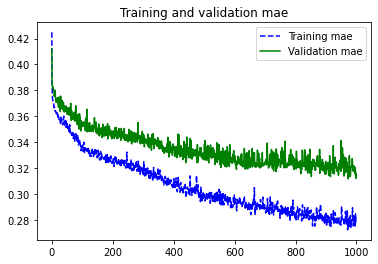

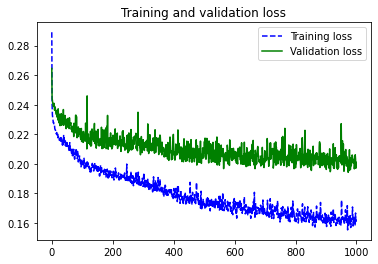

In [337]:
plot_training_analysis(history)

In [334]:
model3 = models.load_model('.mdl_wts.hdf5')
model3.evaluate(x_test,y_test)

15/15 [==============================] - 0s 1ms/step - loss: 0.1567 - mae: 0.2798


[0.15672671794891357, 0.2798365354537964]

In [335]:
y_pred=model3.predict(x_test)
angle_error(y_test,y_pred)

(461,)


0.6566846040615973

In [ ]:
# MAE min : 0.28
# angle_error : 0.66

# imagettes 9x9

In [1]:
# path_9x9 = "Data/train_data/imagettes_9x9_100/"
path_9x9_new = "Data/train_data/imagettes_9x9_new/"

In [6]:
# Chargement de seulement 10 images
sz_9x9=9
xx, yy = load_data(sz_9x9,1764,path_9x9_new)

In [437]:
from sklearn.model_selection import train_test_split
xx_train,xx_test,yy_train,yy_test=train_test_split(xx,yy,test_size=0.1,random_state=123)

In [ ]:
def my_linspace(start,num,step) :
    return np.arange(0,num)*step+start

In [443]:
l1=0
l2=0

model9 = models.Sequential()
model9.add(Flatten())
model9.add(Dense(64,activation='relu',kernel_regularizer=regularizer))
model9.add(Dense(64,activation='relu',kernel_regularizer=regularizer))
model9.add(Dense(32,activation='relu',kernel_regularizer=regularizer))
model9.add(Dense(32,activation='relu',kernel_regularizer=regularizer))
model9.add(Dense(16,activation='relu',kernel_regularizer=regularizer))
model9.add(Dense(8,activation='relu',kernel_regularizer=regularizer))
model9.add(Dense(3,activation='linear'))
# model9 = models.load_model('.mdl9_wts015.hdf5')

# On utilise Adam, un optimiseur simple, et l'on minimise une entropie croisée binaire
opt = keras.optimizers.Adam(learning_rate=3e-3) 
#Loss= tf.keras.losses.mean_squared_error(y_true, y_pred)

model9.compile(loss='mse',
              optimizer=opt,
              metrics='mae')

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl9_wts.hdf5', save_best_only=True, monitor='val_mae', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model9.fit(xx_train, yy_train,
          epochs=1000,
          validation_data = (xx_test, yy_test),
          batch_size=50,verbose=1,
          callbacks=[mcp_save])

Epoch 1/1000
153/153 [==============================] - 1s 4ms/step - loss: 0.2566 - mae: 0.3926 - val_loss: 0.2485 - val_mae: 0.3902
Epoch 2/1000
153/153 [==============================] - 0s 3ms/step - loss: 0.2474 - mae: 0.3890 - val_loss: 0.2456 - val_mae: 0.3892
Epoch 3/1000
153/153 [==============================] - 0s 3ms/step - loss: 0.2444 - mae: 0.3880 - val_loss: 0.2458 - val_mae: 0.3900
Epoch 4/1000
153/153 [==============================] - 1s 3ms/step - loss: 0.2424 - mae: 0.3870 - val_loss: 0.2447 - val_mae: 0.3940
Epoch 5/1000
153/153 [==============================] - 0s 3ms/step - loss: 0.2393 - mae: 0.3846 - val_loss: 0.2379 - val_mae: 0.3884
Epoch 6/1000
153/153 [==============================] - 0s 3ms/step - loss: 0.2382 - mae: 0.3840 - val_loss: 0.2379 - val_mae: 0.3862
Epoch 7/1000
153/153 [==============================] - 0s 3ms/step - loss: 0.2367 - mae: 0.3828 - val_loss: 0.2353 - val_mae: 0.3814
Epoch 8/1000
153/153 [==============================] - 0s 3ms

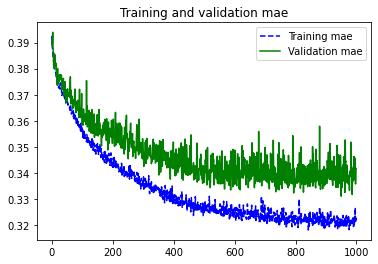

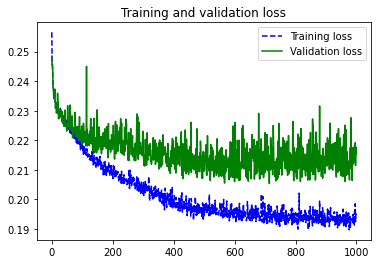

In [444]:
plot_training_analysis(history)

In [445]:
model9 = models.load_model('.mdl9_wts.hdf5')
model9.evaluate(xx_test,yy_test)

27/27 [==============================] - 0s 2ms/step - loss: 0.2079 - mae: 0.3311


[0.20791533589363098, 0.3310772180557251]

In [446]:
yy_pred = model9.predict(xx_test)
angle_error(yy_test,yy_pred)

(847,)


0.7745616515857995

In [ ]:
# mae min : 0.15
# angle_error : 0.33

In [7]:
model9 = models.load_model('.mdl9_wts015.hdf5')
y_pred = model9.predict(xx)

In [ ]:
model9.evaluate(xx,yy)

In [8]:
y_pred_rs = np.reshape(y_pred,(42,42,3))
y_rs = np.reshape(yy,(42,42,3))

In [9]:
y_dict = {"normals_pred_new":y_pred_rs,"normals_true_new":y_rs}

In [10]:
savemat("normals_new.mat",y_dict)

# imagettes 13x13

In [380]:
path_13x13 = "Data/train_data/imagettes_13x13/"

In [382]:
sz_13x13=13
x13, y13 = load_data(sz_13x13,1444,path_13x13)

In [383]:
from sklearn.model_selection import train_test_split
x13_train,x13_test,y13_train,y13_test=train_test_split(x13,y13,test_size=0.2,random_state=123)

In [ ]:
def my_linspace(start,num,step) :
    return np.arange(0,num)*step+start

In [408]:
l1=0
l2=0

model13 = models.Sequential()
model13.add(Conv1D(64,3,activation='relu'))
model13.add(Conv1D(32,3,activation='relu'))
model13.add(Conv1D(16,3,activation='relu'))
model13.add(Flatten())
model13.add(Dense(16,activation='relu',kernel_regularizer=regularizer))
model13.add(Dense(8,activation='relu',kernel_regularizer=regularizer))
model13.add(Dense(3,activation='linear'))
# model13 = models.load_model('.mdl13_wts016.hdf5')

# On utilise Adam, un optimiseur simple, et l'on minimise une entropie croisée binaire
opt = keras.optimizers.Adam(learning_rate=3e-3) 
#Loss= tf.keras.losses.mean_squared_error(y_true, y_pred)

model13.compile(loss='mse',
              optimizer=opt,
              metrics='mae')

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl13_wts.hdf5', save_best_only=True, monitor='val_mae', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model13.fit(x13_train, y13_train,
          epochs=1000,
          validation_data = (x13_test, y13_test),
          batch_size=50,verbose=1,
          callbacks=[mcp_save])

Epoch 1/1000
24/24 [==============================] - 1s 16ms/step - loss: 0.3116 - mae: 0.4553 - val_loss: 0.2930 - val_mae: 0.4381
Epoch 2/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.2937 - mae: 0.4413 - val_loss: 0.2862 - val_mae: 0.4364
Epoch 3/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.2876 - mae: 0.4357 - val_loss: 0.2785 - val_mae: 0.4289
Epoch 4/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.2815 - mae: 0.4283 - val_loss: 0.2714 - val_mae: 0.4157
Epoch 5/1000
24/24 [==============================] - 0s 5ms/step - loss: 0.2712 - mae: 0.4163 - val_loss: 0.2706 - val_mae: 0.4039
Epoch 6/1000
24/24 [==============================] - 0s 7ms/step - loss: 0.2704 - mae: 0.4106 - val_loss: 0.2587 - val_mae: 0.4037
Epoch 7/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.2644 - mae: 0.4034 - val_loss: 0.2620 - val_mae: 0.4060
Epoch 8/1000
24/24 [==============================] - 0s 6ms/step - loss: 0

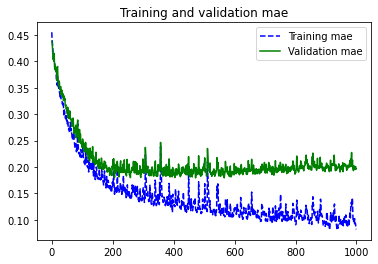

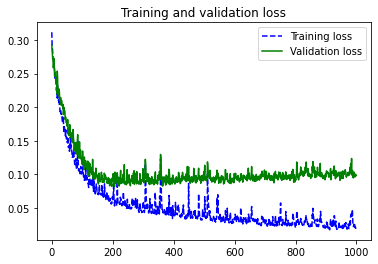

In [409]:
plot_training_analysis(history)

In [410]:
model13 = models.load_model('.mdl13_wts.hdf5')
model13.evaluate(x13_test,y13_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.0879 - mae: 0.1792


[0.08789216727018356, 0.17922329902648926]

In [411]:
y13_pred = model13.predict(x13_test)
angle_error(y13_test,y13_pred)

(289,)


0.3821900504521623

In [ ]:
# mae min : 0.16
# angle_error : 0.34